In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder  
print(__doc__)
from itertools import cycle
from sklearn.model_selection import cross_val_score
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
le = LabelEncoder()

data_fundus = pd.read_csv("data_fundus.csv")
data_fundus_prediction = pd.read_csv("data_fundus_prediction.csv")

data_fundus.shape, data_fundus_prediction.shape

Automatically created module for IPython interactive environment


((1566, 5), (1566, 5))

In [ ]:
# fundus data set edema

In [2]:
# set data variables 
X_bin_edema = np.array(data_fundus[["answer","record_id","doctor"]]).astype(int)

y_bin_edema = np.array(data_fundus["y"]).astype(int)
y_bin_edema[y_bin_edema == 2] = 0
y_bin_edema.shape, X_bin_edema.shape

((1566,), (1566, 3))

In [181]:
# fundus data set atrophy

In [3]:
# set data variables 
X_bin_atrophy = np.array(data_fundus[["answer","record_id","doctor"]]).astype(int)

y_bin_atrophy = np.array(data_fundus["y"]).astype(int)
y_bin_atrophy[y_bin_atrophy == 1] = 2
y_bin_atrophy[y_bin_atrophy == 0] = 1
y_bin_atrophy[y_bin_atrophy == 2] = 0

y_bin_atrophy.shape, X_bin_atrophy.shape

((1566,), (1566, 3))

In [ ]:
# fundus prediction set edema

In [4]:
# set data variables 
X_bin_edema_fp = np.array(data_fundus_prediction[["answer","record_id","doctor"]]).astype(int)

y_bin_edema_fp = np.array(data_fundus_prediction["y"]).astype(int)
y_bin_edema_fp[y_bin_edema_fp == 2] = 0
y_bin_edema_fp.shape, X_bin_edema_fp.shape

((1566,), (1566, 3))

In [ ]:
# fundus prediction set atrophy

In [5]:
# set data variables 
X_bin_atrophy_fp = np.array(data_fundus_prediction[["answer","record_id","doctor"]]).astype(int)

y_bin_atrophy_fp = np.array(data_fundus_prediction["y"]).astype(int)
y_bin_atrophy_fp[y_bin_atrophy_fp == 1] = 2
y_bin_atrophy_fp[y_bin_atrophy_fp == 0] = 1
y_bin_atrophy_fp[y_bin_atrophy_fp == 2] = 0

y_bin_atrophy_fp.shape, X_bin_atrophy_fp.shape

((1566,), (1566, 3))

In [6]:
def kfold_log_reg(X_bin, y_bin):
    stat_dict = {}
    # #############################################################################
    # Classification and ROC analysis

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=10)
    classifier = svm.SVC(kernel='linear', probability=True)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X_bin, y_bin):
        probas_ = classifier.fit(X_bin[train], y_bin[train]).predict_proba(X_bin[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_bin[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        i += 1
   

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    stat_dict["mean_tpr"] = mean_tpr
    stat_dict["mean_fpr"] = mean_fpr
    stat_dict["mean_auc"] = auc(mean_fpr, mean_tpr)
    stat_dict["std_auc"] = np.std(aucs)
    stat_dict["std_tpr"] = np.std(tprs, axis=0)
    return stat_dict

In [7]:
# model without prediction values
stat_dict_atrophy = kfold_log_reg(X_bin_atrophy, y_bin_atrophy)
stat_dict_edema = kfold_log_reg(X_bin_edema, y_bin_edema)

# model with prediction values
stat_dict_atrophy_fp = kfold_log_reg(X_bin_atrophy_fp, y_bin_atrophy_fp)
stat_dict_edema_fp = kfold_log_reg(X_bin_edema_fp, y_bin_edema_fp)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


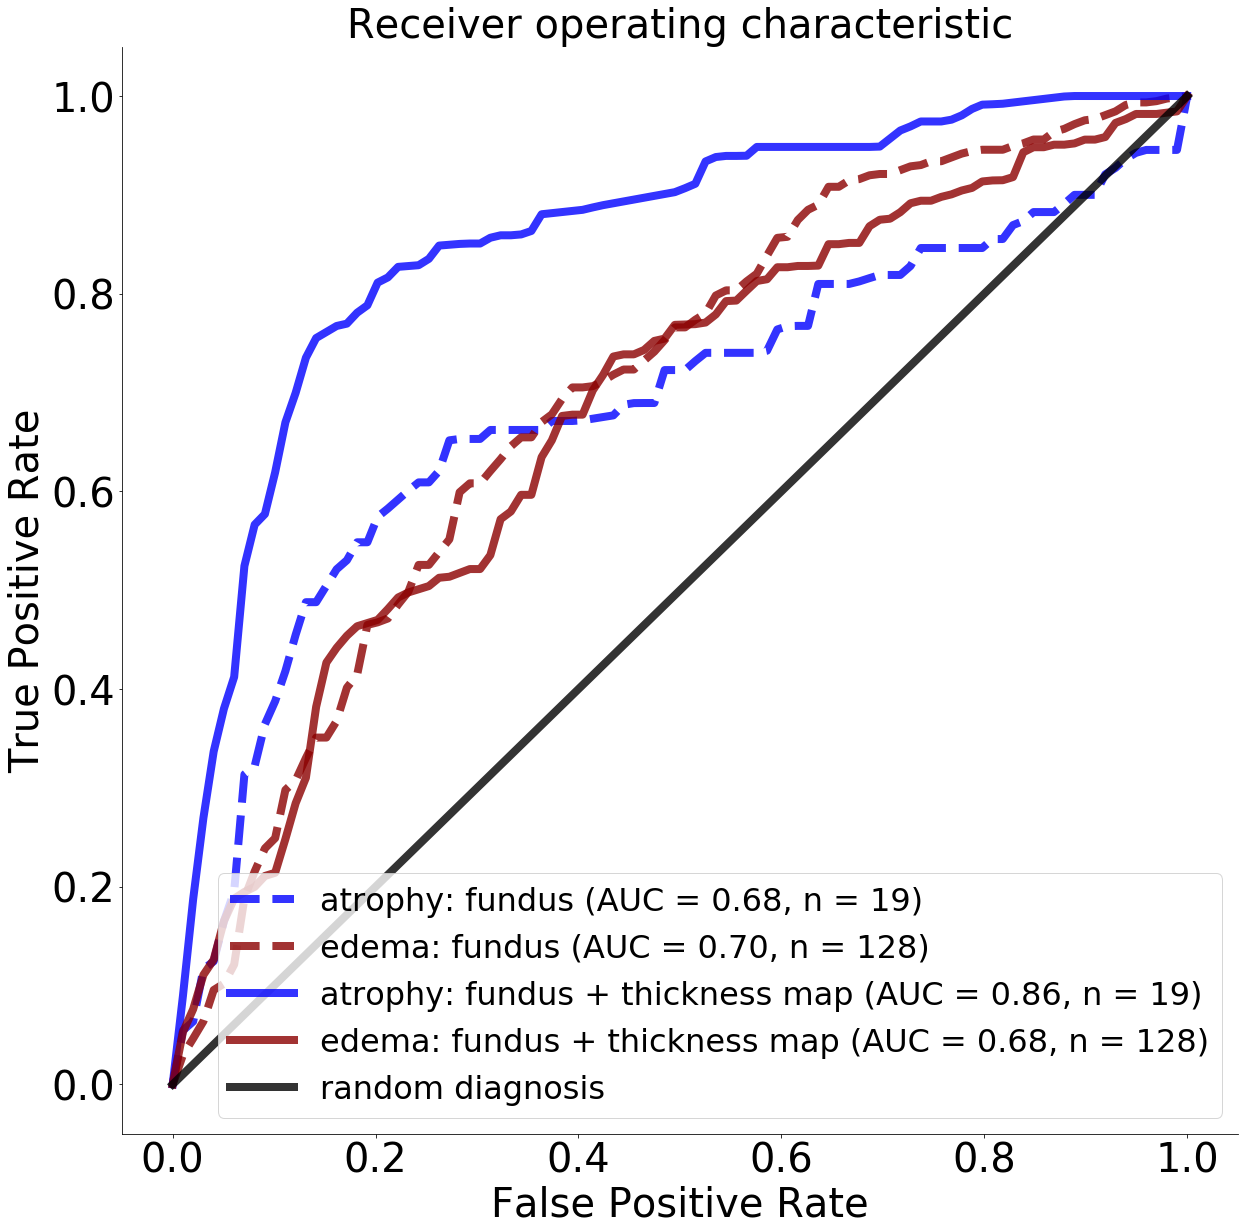

In [8]:
plt.figure(figsize=(20,20))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

plt.plot(stat_dict_atrophy["mean_fpr"], 
         stat_dict_atrophy["mean_tpr"], 
         color='blue',
         linestyle='--',
         lw=8,
         label=r'atrophy: fundus (AUC = %0.2f, n = 19)' % (stat_dict_atrophy["mean_auc"]),
          alpha=.8)


plt.plot(stat_dict_edema["mean_fpr"], 
         stat_dict_edema["mean_tpr"], 
         color='darkred',
         linestyle='--',
         lw=8,
         label=r'edema: fundus (AUC = %0.2f, n = 128)' % (stat_dict_edema["mean_auc"]),
          alpha=.8)

# with prediction values
plt.plot(stat_dict_atrophy_fp["mean_fpr"], 
         stat_dict_atrophy_fp["mean_tpr"],
         color='blue',
         linestyle='-',
         lw=8,
         label=r'atrophy: fundus + thickness map (AUC = %0.2f, n = 19)' % (stat_dict_atrophy_fp["mean_auc"]),
          alpha=.8)

plt.plot(stat_dict_edema_fp["mean_fpr"], 
         stat_dict_edema_fp["mean_tpr"], 
         color='darkred',
         linestyle='-',
         lw=8,
         label=r'edema: fundus + thickness map (AUC = %0.2f, n = 128)' % (stat_dict_edema_fp["mean_auc"]),
          alpha=.8)


plt.plot([0, 1], [0, 1], linestyle='-', lw=8, color='black',
         label='random diagnosis', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.tick_params( labelsize=40)
plt.xlabel('False Positive Rate',size=40)
plt.ylabel('True Positive Rate',size=40)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Receiver operating characteristic',size=40)
plt.legend(loc="lower right",
           prop={'size': 32})
plt.savefig("roc_a_e_n_eval.png", transparent=True)